 # Prediction of gene expression levels in *Streptococcus Thermophilus*

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import xgboost as xgboost
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import pickle
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC

## Data arrangement and pre-processing

In [2]:
# Load the promoter sequences

filtered_promoter_file_path = r"C:\Users\anaca\Documents\Bioinformática\2_semestre\projeto\gene-expression-prediction-from-promoter-sequences\promoter-extraction-and-filtering\filtered_promoters_300_bp.fasta"

def read_filtered_promoters(file_path):
    """
    Reads the filtered promoters from a file and returns each line
    :param file_path: path to the file with the filtered promoters
    :return: lines of the file
    """
    with open(file_path, "r") as f:
        lines = f.readlines()
    lines = [line.strip() for line in lines]
    lines = [line.split("\t") for line in lines]
    lines = [line[0] for line in lines]
    return lines

# read_filtered_promoters(filtered_promoter_file_path)

In [3]:
# Create a dataframe with the promoter sequences

def create_filtered_promoters_df(filename):
    """
    Creates a dataframe with the filtered promoters
    :param filename: name of the file with the filtered promoters
    :return: dataframe with the filtered promoters indicating if they correspond to the reverse complement of the gene, the locus tag of the gene and its coordiantes.
    """
    lines = read_filtered_promoters(filename)
    df = pd.DataFrame(lines)
    df.columns = ['Promoter Type']
    df[['Promoter Type', 'Locus Tag', "Location Coordinates", "Promoter Sequence"]] = df['Promoter Type'].str.split(';', 4, expand=True)
    return df

filtered_promoter_df = create_filtered_promoters_df(filtered_promoter_file_path)
filtered_promoter_df
# create_filtered_promoters_df(filtered_promoter_file_path)

,Promoter Type,Locus Tag,Location Coordinates,Promoter Sequence
0,Promoter reverse complement,T303_00030,[6254:7709](-),AATCTCAAGATGATATTGTAACTAAGAAACAGTATGATTCAGCTTA...
1,Promoter reverse complement,T303_00075,[13830:14277](-),ATCTGCAAAATGCTTCTGAATATATTGCAATAATTGTCTATTAGTT...
2,Promoter,T303_00145,[25297:25490](+),ACCCGCTTCACGCACAGATGTTGCTCCGATAAATATTATACCATAA...
3,Promoter reverse complement,T303_00160,[27163:27556](-),GTATTCCAAACTGGGCTTCAGACAATGATTATCCTGTAACTCGCTT...
4,Promoter reverse complement,T303_00280,[48923:51347](-),GCGTAAGGTTTGTGGCCAGCCAATTGAAGGCGACGACTAGTAAGGA...
...,...,...,...,...
185,Promoter,T303_09655,[1801620:1802511](+),GCCTAATCAATGGTGGACATGGAGTCTCCACCGCAGCTTCTCCTTA...
186,Promoter reverse complement,T303_09855,[1834873:1835209](-),TTAAGTGACGATAGCCTAGGAGATACACCTGTTCCCATGCCGAACA...
187,Promoter,T303_09885,[1840783:1840921](+),TCTTGTCAACACTTTTTTTGAAGTTTTTTCTCTTCTTCGTGCTGGC...
188,Promoter reverse complement,T303_09900,[1843080:1843215](-),CAAAAGCAAAAAATAAAGCTCAAAAATATTGCAAAAATAGTTAAAT...


In [4]:
# Create dataframe with the gene expression values

expression_data = pd.read_excel(r'C:\Users\anaca\Documents\Bioinformática\2_semestre\projeto\dataset_and_overall_data\table_excel_dataset.xlsx', sheet_name='log2CPM_AllConditions')
expression_df = pd.DataFrame(expression_data, columns=["Locus Tag", "Gene Expression Values for Condition 1 (Mean)"])
expression_df.set_index("Locus Tag", inplace=True)
expression_df

,Gene Expression Values for Condition 1 (Mean)
Locus Tag,
T303_00005,9.794827
T303_00010,8.822171
T303_00015,7.451894
T303_00020,7.297720
T303_00025,7.992131
...,...
T303_09885,0.355902
T303_09890,8.589898
T303_09895,1.157323


In [5]:
# Remove the genes that were filtered in the promoter sequences

# filtered_promoter_df = create_filtered_promoters_df(filtered_promoter_file_path)
filtered_locus_tag_list = filtered_promoter_df['Locus Tag'].tolist()
# print(len(filtered_locus_tag_list))
final_expression_df = expression_df[expression_df.index.isin(filtered_locus_tag_list)]
final_expression_df

,Gene Expression Values for Condition 1 (Mean)
Locus Tag,
T303_00030,9.886140
T303_00075,6.291600
T303_00160,7.037297
T303_00280,8.887957
T303_00380,0.832165
...,...
T303_09655,8.373704
T303_09855,7.553936
T303_09885,0.355902


In [6]:
# Remove the promoter sequences that were not found in the expression data

filtered_expression_genes_List = final_expression_df.index.tolist()
final_promoter_df = filtered_promoter_df[filtered_promoter_df["Locus Tag"].isin(filtered_expression_genes_List)]
final_promoter_df

,Promoter Type,Locus Tag,Location Coordinates,Promoter Sequence
0,Promoter reverse complement,T303_00030,[6254:7709](-),AATCTCAAGATGATATTGTAACTAAGAAACAGTATGATTCAGCTTA...
1,Promoter reverse complement,T303_00075,[13830:14277](-),ATCTGCAAAATGCTTCTGAATATATTGCAATAATTGTCTATTAGTT...
3,Promoter reverse complement,T303_00160,[27163:27556](-),GTATTCCAAACTGGGCTTCAGACAATGATTATCCTGTAACTCGCTT...
4,Promoter reverse complement,T303_00280,[48923:51347](-),GCGTAAGGTTTGTGGCCAGCCAATTGAAGGCGACGACTAGTAAGGA...
5,Promoter,T303_00380,[70692:70851](+),TGCTGGTTCAGTGACACCAAGATAAGCTGAAATAATTGCTGGAAGT...
...,...,...,...,...
185,Promoter,T303_09655,[1801620:1802511](+),GCCTAATCAATGGTGGACATGGAGTCTCCACCGCAGCTTCTCCTTA...
186,Promoter reverse complement,T303_09855,[1834873:1835209](-),TTAAGTGACGATAGCCTAGGAGATACACCTGTTCCCATGCCGAACA...
187,Promoter,T303_09885,[1840783:1840921](+),TCTTGTCAACACTTTTTTTGAAGTTTTTTCTCTTCTTCGTGCTGGC...
188,Promoter reverse complement,T303_09900,[1843080:1843215](-),CAAAAGCAAAAAATAAAGCTCAAAAATATTGCAAAAATAGTTAAAT...


### Extraction of Kmer counts from the potencial promoters of the genes in the dataset

In [7]:
# Create dictionary with locus tag as key and promoter sequence as value

def create_promoter_dict(df):
    """
    Creates a dictionary with the locus tag as key and the promoter sequence as value
    :param df: dataframe with the filtered promoters
    :return: dictionary with the locus tag as key and the promoter sequence as value
    """
    promoters = {}
    for index, row in df.iterrows():
        promoters[row['Locus Tag']] = row['Promoter Sequence']
    return promoters

promoter_dict = create_promoter_dict(final_promoter_df)
promoter_dict

{'T303_00030': 'AATCTCAAGATGATATTGTAACTAAGAAACAGTATGATTCAGCTTATAAAGATTGGCTTAAAGAAAAAGCAAAATCTAATGACAAAGCTCAAAAAGATCTTGCAAAACACGTTAAGTAGATTATCGAAAACGTCTACCTTTAGGTGGTCGTTTTTTTGATAAAATTCCTCGAACGACCTTCAGATTGTGTTATAATAAAAAGGATTGATACTTATAAGCTTATGCTTAAGCTTGGGGAGAGCCTTCAAGCTAATCAGGTATCCAAAGACTGAAGAATGAAACATAAAAAGGAGATTTATC',
 'T303_00075': 'ATCTGCAAAATGCTTCTGAATATATTGCAATAATTGTCTATTAGTTGAACGTTTTGAATTCGTACCAACAAGTCCGATGAATTTCATGACAATTCTCCTTAAAAGTATTATATCTAGTATCATGTTAGCGTTTTCCTAGATAAAAGTCAATTTTCGTTTGATGAGAATACGATTAGACTATTACTTTTGTCATCTTATTCCGAATAGATTATAATAGGATAGATTTAGAAAATATTCTTCTTAATTCAGTGTAGATGATTTTACAAGAATTAGTTAACTGATGTATTGAAAGGAAAAATA',
 'T303_00160': 'GTATTCCAAACTGGGCTTCAGACAATGATTATCCTGTAACTCGCTTTGACCAAGTCGGTCCTGCTTCTTGGGAAATTGTGGTTCAAAAACGTTGAGTTAGCTAAGCGAGTCGATAAAATTTAAAGGTCAGTTTTGGTAATGAAAATATCCTATGGAGTACTATTTCTAGAAAAATAATAACCTTCGAGTGGTAGAGAGACTCGAGTATTAGAAAGGATCCTCCCGAAAAAATTTGTAAAACTATTGAAAATAAACCACTTTTTTATTGCCTCTTACGAATAGATAGGTGGAGGTAAAAAA',
 'T303_00280': 'GCGTAAGGTTTGTGGCCAGCCAATTGA

In [21]:
# Generate Kmer from the promoter sequences

def generate_kmer_dictionary(promoter_dictionary, k):
    """
    Generates the kmer from the promoter sequences
    :param promoter_dictionary: dictionary with the locus tag as key and the promoter sequence as value
    :param k: length of the kmer
    :return: dictionary with the locus tag as key and a list of the kmer as value
    """
    kmer_dict = {}
    for key, value in promoter_dictionary.items():
        kmer_dict[key] = {}
        for bp in range(len(value) - k + 1):
            kmer_dict[key][value[bp:bp + k]] = 0

    return kmer_dict
    # print(list(kmer_dict.values())[0])

kmers = generate_kmer_dictionary(promoter_dict, 6)
kmers

{'T303_00030': {'AATCTC': 0,
  'ATCTCA': 0,
  'TCTCAA': 0,
  'CTCAAG': 0,
  'TCAAGA': 0,
  'CAAGAT': 0,
  'AAGATG': 0,
  'AGATGA': 0,
  'GATGAT': 0,
  'ATGATA': 0,
  'TGATAT': 0,
  'GATATT': 0,
  'ATATTG': 0,
  'TATTGT': 0,
  'ATTGTA': 0,
  'TTGTAA': 0,
  'TGTAAC': 0,
  'GTAACT': 0,
  'TAACTA': 0,
  'AACTAA': 0,
  'ACTAAG': 0,
  'CTAAGA': 0,
  'TAAGAA': 0,
  'AAGAAA': 0,
  'AGAAAC': 0,
  'GAAACA': 0,
  'AAACAG': 0,
  'AACAGT': 0,
  'ACAGTA': 0,
  'CAGTAT': 0,
  'AGTATG': 0,
  'GTATGA': 0,
  'TATGAT': 0,
  'ATGATT': 0,
  'TGATTC': 0,
  'GATTCA': 0,
  'ATTCAG': 0,
  'TTCAGC': 0,
  'TCAGCT': 0,
  'CAGCTT': 0,
  'AGCTTA': 0,
  'GCTTAT': 0,
  'CTTATA': 0,
  'TTATAA': 0,
  'TATAAA': 0,
  'ATAAAG': 0,
  'TAAAGA': 0,
  'AAAGAT': 0,
  'AAGATT': 0,
  'AGATTG': 0,
  'GATTGG': 0,
  'ATTGGC': 0,
  'TTGGCT': 0,
  'TGGCTT': 0,
  'GGCTTA': 0,
  'GCTTAA': 0,
  'CTTAAA': 0,
  'TTAAAG': 0,
  'AAAGAA': 0,
  'AGAAAA': 0,
  'GAAAAA': 0,
  'AAAAAG': 0,
  'AAAAGC': 0,
  'AAAGCA': 0,
  'AAGCAA': 0,
  'AGCAAA':

In [22]:
# Count the number of times each kmer appears in the promoter sequences

def count_kmer(kmer_dict, promoter_dictionary, k):
    """
    Counts the number of times each kmer appears in the promoter sequences
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer as value
    :param promoter_dictionary: dictionary with the locus tag as key and the promoter sequence as value
    :param k: length of the kmer
    :return: dictionary with the locus tag as key and a list of the kmer and its count in the promoter sequence as value
    """
    for key, value in promoter_dictionary.items():
        for bp in range(len(value) - k + 1):
            kmer_dict[key][value[bp:bp+k]] += 1
    return kmer_dict

kmer_count_dict = count_kmer(kmers, promoter_dict, 6)
kmer_count_dict

{'T303_00030': {'AATCTC': 1,
  'ATCTCA': 1,
  'TCTCAA': 1,
  'CTCAAG': 1,
  'TCAAGA': 1,
  'CAAGAT': 1,
  'AAGATG': 1,
  'AGATGA': 1,
  'GATGAT': 1,
  'ATGATA': 1,
  'TGATAT': 1,
  'GATATT': 1,
  'ATATTG': 1,
  'TATTGT': 1,
  'ATTGTA': 1,
  'TTGTAA': 1,
  'TGTAAC': 1,
  'GTAACT': 1,
  'TAACTA': 1,
  'AACTAA': 1,
  'ACTAAG': 1,
  'CTAAGA': 1,
  'TAAGAA': 1,
  'AAGAAA': 2,
  'AGAAAC': 1,
  'GAAACA': 2,
  'AAACAG': 1,
  'AACAGT': 1,
  'ACAGTA': 1,
  'CAGTAT': 1,
  'AGTATG': 1,
  'GTATGA': 1,
  'TATGAT': 1,
  'ATGATT': 1,
  'TGATTC': 1,
  'GATTCA': 1,
  'ATTCAG': 1,
  'TTCAGC': 1,
  'TCAGCT': 1,
  'CAGCTT': 1,
  'AGCTTA': 2,
  'GCTTAT': 2,
  'CTTATA': 2,
  'TTATAA': 3,
  'TATAAA': 1,
  'ATAAAG': 1,
  'TAAAGA': 2,
  'AAAGAT': 2,
  'AAGATT': 1,
  'AGATTG': 2,
  'GATTGG': 1,
  'ATTGGC': 1,
  'TTGGCT': 1,
  'TGGCTT': 1,
  'GGCTTA': 1,
  'GCTTAA': 2,
  'CTTAAA': 1,
  'TTAAAG': 1,
  'AAAGAA': 1,
  'AGAAAA': 1,
  'GAAAAA': 1,
  'AAAAAG': 4,
  'AAAAGC': 1,
  'AAAGCA': 1,
  'AAGCAA': 1,
  'AGCAAA':

In [23]:
# Check wich kmer appears more than once in the promoter sequences

def return_kmers_with_counts_above_threshold(kmer_dict, threshold):
    """
    Returns the kmers that appear more than theshold times in the promoter sequences
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer as value
    :param threshold: number of times the kmer must appear in the promoter sequence
    :return: filtered dictionary with the locus tag as key and a list of the kmer with counts above threshold as value
    """
    kmer_dict_filtered = {}
    for key, value in kmer_dict.items():
        kmer_dict_filtered[key] = {}
        for kmer, count in value.items():
            if count > threshold:
                kmer_dict_filtered[key][kmer] = count
        if len(kmer_dict_filtered[key]) == 0:
            del kmer_dict_filtered[key]
    return kmer_dict_filtered

return_kmers_with_counts_above_threshold(kmer_count_dict, 1)

{'T303_00030': {'AAGAAA': 2,
  'GAAACA': 2,
  'AGCTTA': 2,
  'GCTTAT': 2,
  'CTTATA': 2,
  'TTATAA': 3,
  'TAAAGA': 2,
  'AAAGAT': 2,
  'AGATTG': 2,
  'GCTTAA': 2,
  'AAAAAG': 4,
  'GCAAAA': 2,
  'TTTTTT': 2,
  'TTGATA': 2,
  'ATAAAA': 3,
  'CCTTCA': 2,
  'TAAAAA': 2,
  'AAAAGG': 2,
  'AAAGGA': 2,
  'TAAGCT': 2,
  'AAGCTT': 2},
 'T303_00075': {'CTATTA': 2,
  'ATTAGT': 2,
  'TTAGTT': 2,
  'CGTTTT': 2,
  'TGAATT': 2,
  'TAAAAG': 2,
  'AAAAGT': 2,
  'ATTATA': 2,
  'ATAGAT': 2,
  'TAGATT': 2,
  'AAAATA': 2},
 'T303_00160': {'TATCCT': 2,
  'AAAATT': 2,
  'AAATTT': 2,
  'TGAAAA': 2,
  'GAAAAT': 2,
  'AAAATA': 3,
  'ACTATT': 2,
  'TAGAAA': 2,
  'GAAAAA': 2,
  'AAAAAT': 2,
  'AAATAA': 2,
  'TCGAGT': 2,
  'AAAAAA': 2,
  'GTAAAA': 2},
 'T303_00280': {'GTAAGG': 2,
  'GGTTTG': 2,
  'GTTTGT': 2,
  'GCGACG': 2,
  'CGACGA': 2,
  'GAGACT': 2,
  'AGACTG': 2,
  'CTTCTT': 2,
  'TTCTTC': 3,
  'TCTTCA': 3,
  'CTTCAA': 2,
  'TTCAAA': 2,
  'TCAAAG': 2,
  'AGGCTT': 2,
  'GGCTTT': 2,
  'GCTTTT': 2,
  'CTTTTA':

In [24]:
# Create a dataframe with the kmer counts

def create_kmer_feature_table(kmer_dict):
    """
    Creates a dataframe with the kmer counts
    :param kmer_dict: dictionary with the locus tag as key and a list of the kmer and its count in the promoter sequence as value
    :return: dataframe with the kmer counts for each promoter sequence identified by the locus tag
    """
    kmer_feature_table = pd.DataFrame.from_dict(kmer_dict)
    return kmer_feature_table.fillna(0).astype(int).transpose()
    # kmer_feature_table = kmer_feature_table.fillna(0).astype(int)
    # more_2 = kmer_feature_table[kmer_feature_table.isin([2]).any(axis=1)]
    # print(more_2.to_string())

kmer_feature_df = create_kmer_feature_table(kmer_count_dict)
kmer_feature_df

,AATCTC,ATCTCA,TCTCAA,CTCAAG,TCAAGA,CAAGAT,AAGATG,AGATGA,GATGAT,ATGATA,...,GCACCC,ACCGCA,CAGGGC,CGACAC,CCCATG,CGCATG,CGGAGT,GGCCGT,CTGATC,GCCGGC
T303_00030,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
T303_00075,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
T303_00160,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
T303_00280,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
T303_00380,0,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
T303_09655,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,0,0,0,0,0,0
T303_09855,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
T303_09885,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
T303_09900,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1


## Creation of a hierarchical clustering of the kmers

In [25]:
#Calculate the distance between the kmers

matrix = kmer_feature_df
average_distance = linkage(matrix, metric="euclidean", method="ward")

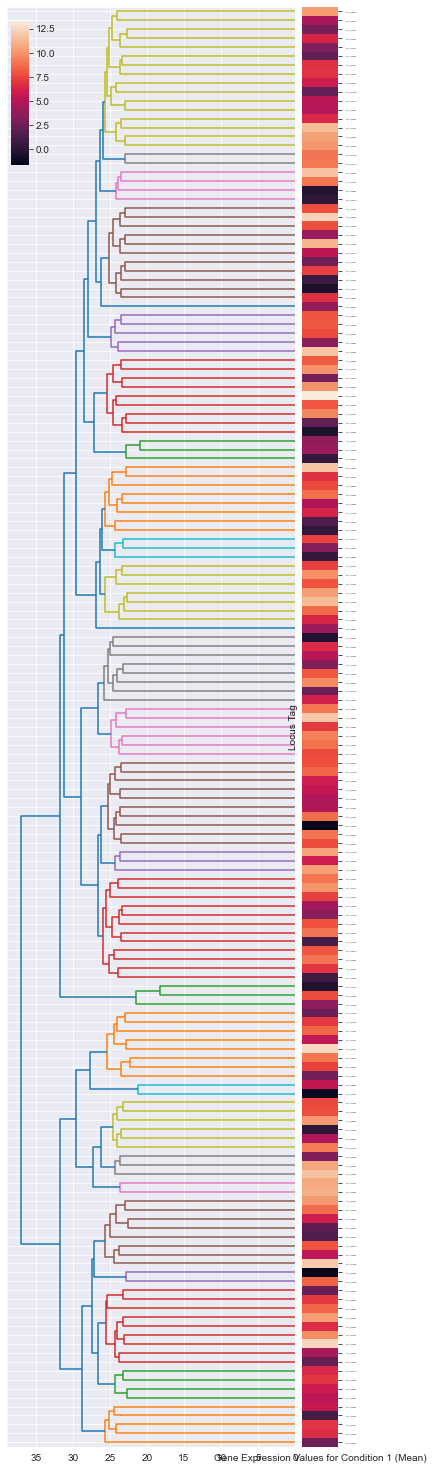

In [26]:
#Define dendogram parameters
den = plt.figure(figsize=[5, 20])
axis_1 = den.add_axes([0, 0, 0.8, 1])

#Plot dendrogram
dendrogram(average_distance, orientation="left", labels=matrix.index, leaf_font_size=1)
leaf_order = [t.get_text() for t in axis_1.get_yticklabels()]

axis_2 = den.add_axes([0.82, 0, 0.1, 1])
axis_3 = den.add_axes([0.01, 0.89, 0.05, 0.1])

#Plot the heatmap
heatmap_data = final_expression_df
heatmap_data = heatmap_data.reindex(leaf_order[::-1])

#Define heatmap parameters
sbn.heatmap(heatmap_data, yticklabels=True, ax=axis_2, cbar_ax=axis_3)
axis_2.yaxis.tick_right()
axis_2.set_yticklabels(axis_2.get_yticklabels(), rotation=0, fontsize=2)

#Save the figure
plt.savefig("dendrogram_300bp_6kmer.pdf", bbox_inches="tight")

None

## Machine learning Pipeline

### Model definition

In [30]:
#Set the model's variables
X = kmer_feature_df #features
Y = final_expression_df #target

#Split the data into training and test sets
x_train, x_test, y_train, y_test =  train_test_split(X, Y)

### Extreme Gradient Boosting

In [31]:
#Define the model -> Extreme Gradient Boosting (XGBoost) is an open-source machine learning library designed to improve the implementation of the gradient boosting algorithm.
model = xgboost.XGBRegressor(eta = 0.1)
model.fit(x_train, y_train)

#Calculate Coefficient of Determination (R-squared)
print("The model's accuracy is %.3f." % model.score(x_test, y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

The model's accuracy is 0.001.
The mean squared error (MSE) on test set is 14.092.


### Feature selection

#### Recursive feature elimination (RFE)

In [ ]:
#Identify and remove features with very low feature importance (low correlation with the target) in order to increase speed
reduced_features_1 = pd.Series(model.feature_importances_, index=x_train.columns)
reduced_features_1 = reduced_features_1[reduced_features_1 >= 0.001].index

#Recursive feature elimination
rfe = RFECV(xgboost.XGBRegressor(eta = 0.1))

#Train with reduced features
rfe.fit(x_train[reduced_features_1], y_train)

#Get ranking of features
rankings = pd.Series(rfe.ranking_, index=reduced_features_1)
reduced_features_2 = rankings[rankings == 1].index
print(len(reduced_features_2))

#Train model on reduced features
model_reduced_features = xgboost.XGBRegressor(eta = 0.1)
model_reduced_features.fit(x_train[reduced_features_2], y_train)

model_reduced_features_prediction = model_reduced_features.predict(x_test[reduced_features_2])

#Calculate the Spearman rank-order correlation coefficient
#Ignore warning of unresolved reference for correlation function:
# noinspection PyUnresolvedReferences
print("The model's Spearman correlation coefficient is %s." %stats.spearmanr(model_reduced_features_prediction, y_test).correlation)

#Calculate Coefficient of Determination (R-squared)
print("The model's accuracy is %.3f." % model_reduced_features.score(x_test[reduced_features_2], y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, model_reduced_features.predict(x_test[reduced_features_2]))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

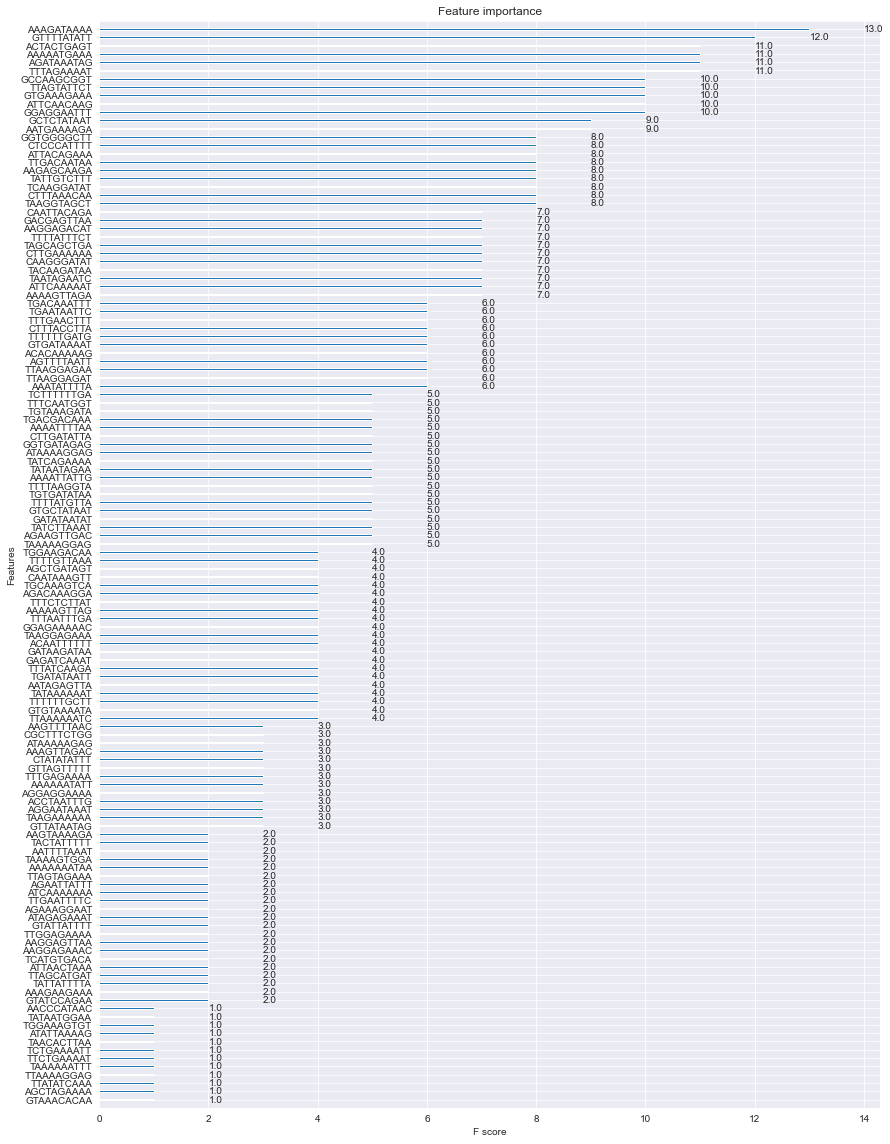

In [23]:
plt.rcParams["figure.figsize"] = (14, 20)
xgboost.plot_importance(model_reduced_features)
plt.show()

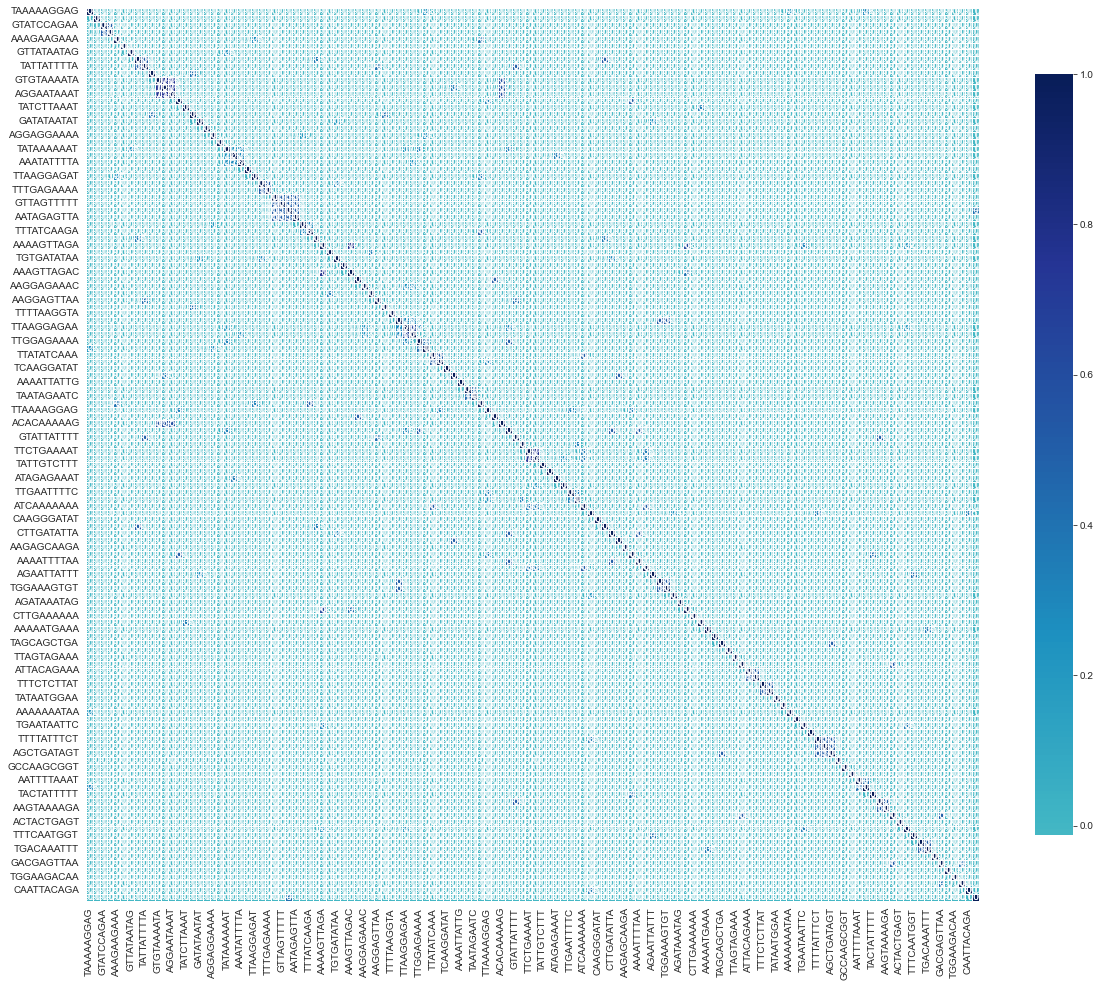

In [29]:
def correlation_heatmap(train):
    correlations = train.corr()

    plt.subplots(figsize=(20,20))
    sbn.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show()

correlation_heatmap(x_train[reduced_features_2])

#### Evaluate optimum number of features for model

An input array is constant; the correlation coefficient is not defined.


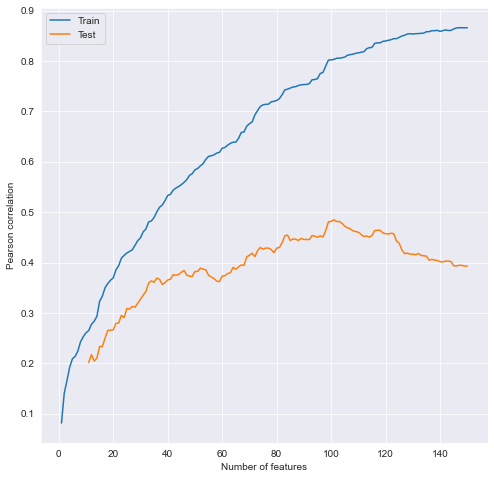

In [28]:
#Calculate performances for the training set
train_performances = []


for i in range(150):
    model_train = xgboost.XGBRegressor(eta = 0.1)
    x_train_subset = x_train[rankings.sort_values()[:i+1].index]
    model_train.fit(x_train_subset, y_train)
    train_model_feature_rank = model_train.predict(x_train_subset)
    train_performances.append(stats.pearsonr(train_model_feature_rank, y_train)[0])

#Calculate performances for the testing set
test_performances = []

splitter = KFold(5, shuffle=True, random_state=2020)

for train_index, test_index in splitter.split(x_train, y_train):
    k_performances = []
    X_train_train, X_train_test = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_train, y_train_test = y_train.iloc[train_index], y_train.iloc[test_index]

    for i in range(150):
        model_test = xgboost.XGBRegressor(eta = 0.1)
        model_test.fit(X_train_train[rankings.sort_values()[:i+1].index], y_train_train)
        test_model_feature_rank = model_test.predict(X_train_test[rankings.sort_values()[:i+1].index])
        k_performances.append(stats.pearsonr(test_model_feature_rank, y_train_test)[0])
    test_performances.append(k_performances)

test_performances = np.array(test_performances, dtype=object).mean(0)

#Plot the different performances
plt.subplots(figsize=(8,8))
plt.plot(range(1, 151), train_performances, label="Train")
plt.plot(range(1, 151), test_performances, label="Test")
plt.legend()
plt.xlabel("Number of features")
plt.ylabel("Pearson correlation")
plt.show()

### Hyperparameter optimization

In [ ]:
model_xgb = xgboost.XGBRegressor(eta = 0.1)
hyper_param_test = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'max_depth': [3, 5, 7, 9]}

model_param_tune = RandomizedSearchCV(model_xgb,
                         param_distributions = hyper_param_test,
                         verbose = 2)

model_param_tune.fit(x_train, y_train)

In [ ]:
model_param_tune.best_params_

### Random Forest Regressor

In [ ]:
# x_train_rf = x_train.values[:,0]
# y_train_rf = y_train.values[:,0]
# x_test_rf = x_test.values[:,0]
# y_test_rf = y_test.values[:,0]

rf_model = RandomForestRegressor()
rf_model.fit(x_train, y_train)

#Calculate Coefficient of Determination (R-squared)
print("The model's accuracy is %.3f." % rf_model.score(x_test, y_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(y_test, rf_model.predict(x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

KeyboardInterrupt: 

### Support Vector Machines

In [39]:
train_instances_nr = len(x_train)
train_instances_nr

520

In [46]:
test_instances_nr = len(x_test)
test_instances_nr

174

In [48]:
svm_x_train = x_train.values.ravel()
svm_y_train = y_train.values.ravel()
svm_x_test = x_test.values.ravel()
svm_y_test = y_test.values.ravel()

svm_model = SVC()
svm_model.fit(svm_x_train, svm_x_train)

#Calculate Coefficient of Determination (R-squared)
print("The model's accuracy is %.3f." % svm_model.score(svm_x_test, svm_x_test))

#Calculate the Mean Squared Error
mse = mean_squared_error(svm_x_test, svm_model.predict(svm_x_test))
print("The mean squared error (MSE) on test set is {:.3f}.".format(mse))

ValueError: Expected 2D array, got 1D array instead:
array=[0. 0. 0. ... 0. 0. 0.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

### Predictions comparison

In [39]:
rankings = pd.Series(rfe.ranking_, index=reduced_features_1)
final_reduced_features = rankings[rankings == 1]
final_reduced_features = final_reduced_features.index.tolist()
final_reduced_features

['TTGATAGAGA',
 'TTTAGAAAAT',
 'GTATCCAGAA',
 'AGAAGTTGAC',
 'TAAGGAGAAT',
 'TAAGGTAGCT',
 'TATTATTTTA',
 'TTCAAAATAT',
 'AAGGATAGAG',
 'AGGAATAAAT',
 'AGGAGAAAAT',
 'TATCTTAAAT',
 'TAAAAAATAA',
 'AATATCAGTC',
 'ATAGAATTGA',
 'ATTTTTAATA',
 'ATATTCTTAT',
 'TGATAGAATA',
 'AAGGAGTTTA',
 'AAATATTTTA',
 'ATTATTTGAT',
 'TTAAGGAGAT',
 'ATAAAATAAT',
 'TTTTATGTTA',
 'AATAGAGTTA',
 'TGATATAATT',
 'GAAATAAATA',
 'AAAAGTTAGA',
 'TGATATAATG',
 'TGTGATATAA',
 'GAGATCAAAT',
 'TAAAATAGAT',
 'AAGGAGAAAC',
 'CTTGTCTATG',
 'ATTCAAAATA',
 'GATAAGATAA',
 'CTTTAAACAA',
 'TTTTAAGGTA',
 'TAAGGAGAAA',
 'TTGGAGAAAA',
 'TTATATCAAA',
 'TTTTTAATAA',
 'TCAAGGATAT',
 'AGTTTTAATT',
 'AAACAAAAAG',
 'TAATAGAATC',
 'ACACAAAAAG',
 'AATGAAGGAG',
 'GTATTATTTT',
 'AAAAGGAGAA',
 'TTTTAGAGGG',
 'CTTTTTATTT',
 'TTGATAAAAA',
 'TAAAAAGTTG',
 'GGTGATAGAG',
 'TTAAAAATAA',
 'AAATATAGAT',
 'TGAGTGCTAA',
 'ATAATAGAAG',
 'GAATTTTCAG',
 'GTGATAAAAT',
 'ATCAAAAAAA',
 'ATGGACTCAA',
 'AAGAAAAGGC',
 'ATTAAGGAGA',
 'CTTGATATTA',
 'AAAAAATT

InvalidIndexError: (slice(None, None, None), None)

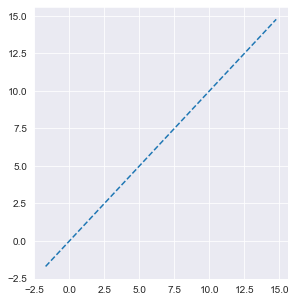

In [42]:
#Compare the predictions and measurements by plot and the spearman correlation coefficient
plt.figure(figsize=[10, 5])

#Plot for the training set
plt.subplot(1, 2, 1)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "--")
plt.plot(model_reduced_features.predict(x_train[reduced_features_2]), y_train, ".")

#Plot for the testing set
plt.subplot(1, 2, 2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "--")
plt.plot(model_reduced_features_prediction, y_test, ".")

print(stats.spearmanr(model_reduced_features_prediction, y_test))

In [ ]:
#Save the model
pickle.dump(model, open('model.sav', 'wb'))

In [22]:
#or dedicated SHAP function

def shap_importances(x,
                     trained_model,
                     n_features=30,
                     plot=None,
                     n_non_genetic_features=0,
                     tax_dict=None):
    """
    ONLY for tree models!
    Gets the most important features, as identified by Shap and makes Shap
    feature importance plots.
    Learn more about Shap: https://github.com/slundberg/shap
    If the plot list contains 'summary', a Shap summary plot will be made.
    If the plot list contains any strain IDs (from the index of X), the
    function also makes individual Shap plots for each prediction for those
    strain IDs. All plots are returned in a dictionary.

    Input:
    -------
    X: Pandas DataFrame.
        Strain IDs in index, features in the columns.
    trained_model: Trained scikit learn tree model.
    n_features: Integer (default=30).
        Number of the highest importance features to plot and return.
    plot: List (default=[]).
        Can contain the values 'summary' and IDs from X.index.
        If the list is empty, no plots are made.
        If it contains 'summary' it makes Shap feature importance plot.
        If it contains IDs from X.index it makes Shap plots for each sample.
    n_non_genetic_features: Integer (default=0).
        Number of non-genetic features. This is used for names and labels in
        the individual sample plots.
    tax_dict: Dictionary.
        Strain IDs as keys and taxonomy values. This is used for labels in
        the individual sample plots.

    Returns:
    --------
    top_features: List of strings.
        List of the highest importance features (corresponding to the plot).
        Only returns the n_features top features.
    figures: Dictionary.
        Dictionary of Shap plots. Plot names as keys, plots as values.
        The plot names are either 'summary' or they start with a strain ID
        and contain information on the contition values of the sample.
        Print the dictionary keys to see: print(figures.keys())
    """

    if plot is None:
        plot = []
    for p in plot:
        if p not in ['summary'] + list(x.index):
            raise Exception('"plot" contains invalid values.')

    # Explain the model's predictions with SHAP values:
    model_explainer = shap.TreeExplainer(trained_model)
    shap_values = model_explainer.shap_values(x)

    figures = {}

    if 'summary' in plot:
        fig_2 = plt.figure()
        # Plot the effects of the features:
        shap.summary_plot(shap_values, x, max_display=n_features, show=False)
        figures['summary'] = fig_2

    # Get numeric index of which rows (samples) of X to plot:
    rows = [row for row in range(len(x)) if x.index[row] in plot]

    # Plot the effects of the features for each individual prediction:
    for i in rows:
        fig_2 = shap.force_plot(model_explainer.expected_value,
                              shap_values[i, :],
                              x.iloc[i, :],
                              matplotlib=True,
                              show=False)  # If show=True fig is empty
        if n_non_genetic_features > 0:
            # Put label on x-axis to know which sample it is:
            # X.index[i] is the strain ID
            # tax_dict[X.index[i]] is the taxonomy
            # X.columns is the feature list
            plt.xlabel(x.index[i] + ', ' + tax_dict[x.index[i]] + ', ' +
                       ', '.join([x.columns[j] + '=' + str(x.iloc[i, j])
                                  for j in range(n_non_genetic_features)]))
            name = x.index[i] + '__'
            name += '__'.join([x.columns[j] + '_' + str(x.iloc[i, j])
                               for j in range(n_non_genetic_features)])
            figures[name] = fig_2
        else:
            # Put label on x-axis to know which sample it is:
            plt.xlabel(x.index[i] + ', ' + tax_dict[x.index[i]])
            figures[x.index[i]] = fig_2

    top_features = x.columns[np.argsort(np.abs(shap_values).mean(0))[::-1]]
    top_features = list(top_features)[:n_features]

    return top_features, figures

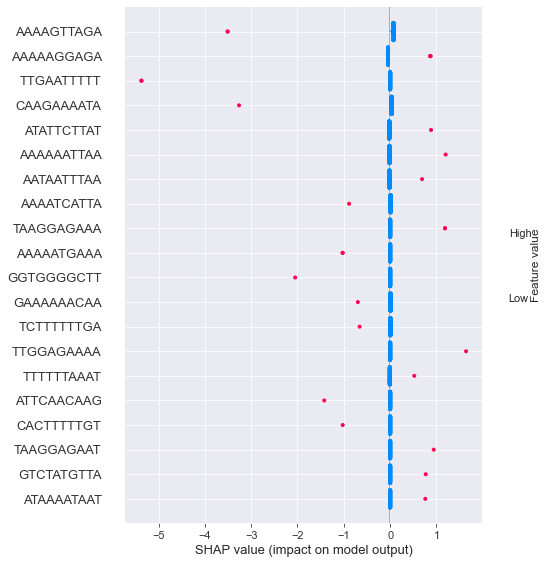

Exception: Model type not yet supported by TreeExplainer: <class 'pandas.core.frame.DataFrame'>

In [23]:
#Basic SHAP commands
shap.initjs()

model_explainer_2 = shap.TreeExplainer(model_reduced_features, x_test[reduced_features_2])
shap_values_2 = model_explainer_2.shap_values(x_test[reduced_features_2])

shap.summary_plot(shap_values_2, x_test[reduced_features_2])

shap_importance_df = shap_importances(model_reduced_features, x_test[reduced_features_2])
shap_importance_df = shap_importance_df[0:20]


fig = plt.figure()
ax = fig.add_axes([0, 0, 0.8, 0.8])

shap.summary_plot(shap_values_2, x_test[reduced_features_2])
shap.summary_plot(shap_values_2, x_test[reduced_features_2], show=False)
plt.savefig("shap_summary_plot3.pdf")
plt.close()